In [1]:
# Importer les bibliotheque
from ultralytics import YOLO
import matplotlib.pyplot as plt
import cv2
import math
import cvzone
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
import os

In [9]:
def License_Plate_Detection(frame,model_path):  # Fonction qui reçoit le modèle et une image
    classname=['License_plate']
    model_detection=YOLO(model_path) 
    results=model_detection(frame) 
    for info in results:
     parametres=info.boxes
     for box in parametres:
        x1,y1,x2,y2=box.xyxy[0] # Récupérer les 4 points qui encadrent la plaque d'immatriculation
        if None in [x1,y1,x2,y2]:
           return None
        else:
            x1,y1,x2,y2=int(x1),int(y1),int(x2),int(y2)
            x1-=5
            y1-=5
            x2+=5
            y2+=5
            confidence=box.conf[0] # Confiance du modèle sur ce résultat 
            class_detect=box.cls[0]
            class_detect=int(class_detect)
            class_detect=classname[class_detect]
            conf=math.ceil(confidence*100)
            if(conf>40) and class_detect=='License_plate':  
                cv2.rectangle(frame,(x1,y1),(x2,y2),(0,255,0),2)
                cvzone.putTextRect(frame, f'{conf}%', [x1+4, y1-8],thickness=4)
        plate=frame[y1:y2,x1:x2]
        croped_img=plate[1:-1,1:-1]
        return croped_img,frame # La fonction renvoie la plaque extraite ainsi que l'image originale avec la plaque encadrée


0: 384x640 1 LicensePlate, 233.2ms
Speed: 16.6ms preprocess, 233.2ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


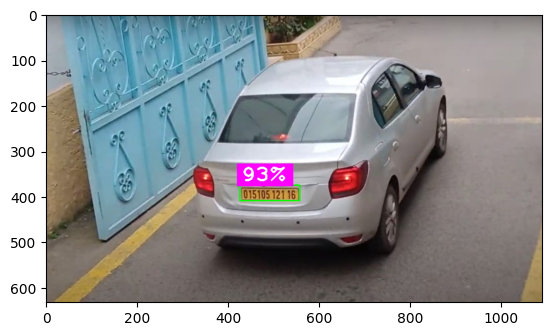

In [10]:
image = cv2.imread('Images/T (108).jpg')

model='models/best.pt'
rs1,rs2=License_Plate_Detection(image,model)
plt.imshow(cv2.cvtColor (rs2, cv2.COLOR_BGR2RGB))

In [4]:
def Perspective_Transformation(model_path,plate):
    model=YOLO(model_path)
    results=model(plate)
    for res in results:
        keypoints  = res.keypoints.xy.numpy().astype(int)
    def order_points(points):
        points_sum=np.sum(points,axis=1)
        points_df=np.diff(points,axis=1)
        x1=points[np.argmin(points_sum)]
        x4=points[np.argmax(points_sum)]
        x2=points[np.argmin(points_df)]
        x3=points[np.argmax(points_df)]
        return x1,x2,x3,x4
    w , h= 240,60
    if len(keypoints[0])==0:
        return None
    else:
        x1,x2,x3,x4=order_points(keypoints[0])
        pts1 = np.float32([x1,x2,x3,x4])
        pts2 =np.float32([[0,0], [w,0], [0,h], [w,h]])
        M = cv2.getPerspectiveTransform(pts1,pts2)
        dst = cv2.warpPerspective(plate, M, (w,h))
        return dst

In [5]:
def Plate_segmentation(plate,model_path):
    model=YOLO(model_path)
    result=model(plate)[0]
    chars=[]
    crop_chars=[]
    for res in result:
        xyxy  = res.boxes.xyxy.numpy().astype(int)
        if res.boxes.conf.numpy()[0]>0.3:
            xmin,ymin,xmax,ymax=xyxy[0]
            chars.append([xmin,ymin,xmax,ymax])
            cv2.rectangle(plate,(xmin,ymin),(xmax,ymax),(0,255,0),1)
    if(chars==[]):
        return None
    else:
        chars  = np.array(chars)
        sorted_indices = np.argsort(chars[:,0])
        chars = chars[sorted_indices]
        
        def crop_char(image,char):
            xmin,ymin,xmax,ymax=char
            return image[ymin:ymax,xmin:xmax]
        
        for char in chars:
            crop_chars.append(crop_char(plate,char))

        return plate,crop_chars

In [6]:
def Number_Recognition(numbers,model_path):
    license_plate=""
    model_recognition=load_model(model_path)
    def process(image):
        image_resized = cv2.resize(image, (64,64))
        image_resized=cv2.cvtColor (image_resized, cv2.COLOR_RGB2GRAY)
        image_normlized = image_resized/255
        image_normlized = np.expand_dims(image_normlized, 0)
        return image_normlized
    def predict(model,image):
        image =process(image)
        yhat = model.predict(image)
        prediction = np.argmax(yhat, axis=1)
        return prediction[0]
    for img in numbers:
        license_plate+=str(predict(model_recognition,img))
    return license_plate

In [7]:
def LPDR(frame):
    frame=cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame_fin=frame.copy()
    model_dt='models/best.pt'
    model_rec='models/best.h5'
    model_sg='models/best_boy.pt'
    model_kpd='models/kp_detection.pt'
    plt.imshow(frame)
    plt.show()
    plate= License_Plate_Detection(frame, model_dt)
    if plate is None:
            org = (50, 50)
            taille_texte, _ = cv2.getTextSize("No detection", cv2.FONT_HERSHEY_SIMPLEX, 1, 2)
            x, y = org
            w, h = taille_texte[0] + 10, taille_texte[1] + 10
            cv2.rectangle(frame, (x, y), (x + w, y - h), (0, 255, 0), -1)
            org_texte = (x + 5, y - 5)
            cv2.putText(frame, "No detection", org_texte, cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 2, cv2.LINE_AA)
            plt.imshow(frame)
            plt.show()
            return "No detection"
    else:
            plt.imshow(plate)
            plt.show()
            perspective=Perspective_Transformation(model_kpd,plate)
            if perspective is None:
                org = (50, 50)
                taille_texte, _ = cv2.getTextSize("No detection", cv2.FONT_HERSHEY_SIMPLEX, 1, 2)
                x, y = org
                w, h = taille_texte[0] + 10, taille_texte[1] + 10
                cv2.rectangle(frame_fin, (x, y), (x + w, y - h), (0, 255, 0), -1)
                org_texte = (x + 5, y - 5)
                cv2.putText(frame_fin, "No detection", org_texte, cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 2, cv2.LINE_AA)
                plt.imshow(frame_fin)
                plt.show()
                return "No detection"
            else:
                plt.imshow(perspective)
                plt.show()
                plate,chars=Plate_segmentation(perspective,model_sg)
                if(plate is None):
                    return "No detection"
                else:
                    plt.imshow(plate)
                    plt.show()
                    license_plate=Number_Recognition(chars,model_rec)
                    texte = license_plate
                    org = (50, 50)
                    taille_texte, _ = cv2.getTextSize(texte, cv2.FONT_HERSHEY_SIMPLEX, 1, 2)
                    x, y = org
                    w, h = taille_texte[0] + 10, taille_texte[1] + 10
                    cv2.rectangle(frame_fin, (x, y), (x + w, y - h), (0, 255, 0), -1)
                    org_texte = (x + 5, y - 5)
                    cv2.putText(frame_fin, texte, org_texte, cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 2, cv2.LINE_AA)
                    frame_fin=cv2.cvtColor (frame_fin, cv2.COLOR_BGR2RGB)
                    plt.imshow(frame_fin)
                    plt.show()
                    return license_plate

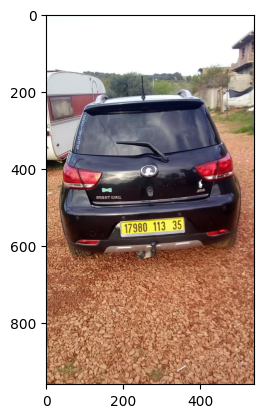


0: 640x384 1 LicensePlate, 232.5ms
Speed: 0.0ms preprocess, 232.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


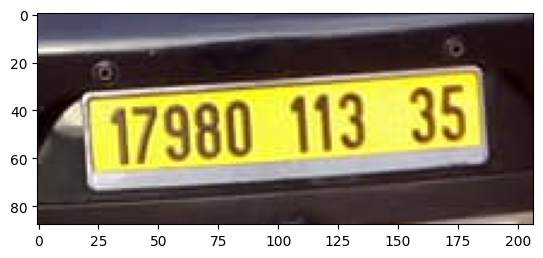


0: 288x640 1 LicensePlate, 206.9ms
Speed: 17.1ms preprocess, 206.9ms inference, 0.0ms postprocess per image at shape (1, 3, 288, 640)


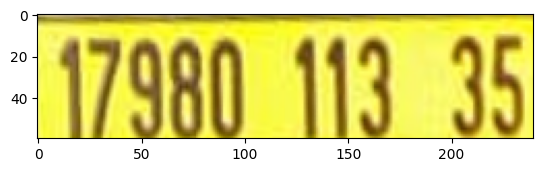


0: 160x640 11 characters, 110.2ms
Speed: 0.0ms preprocess, 110.2ms inference, 0.0ms postprocess per image at shape (1, 3, 160, 640)


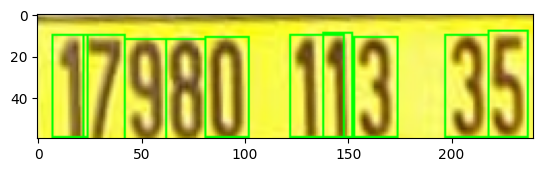

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


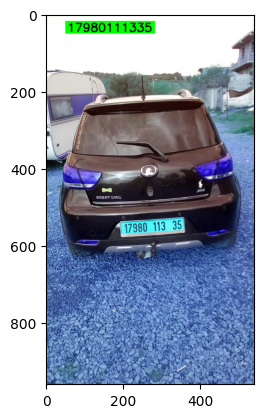

'17980111335'

In [11]:
tester_image=cv2.imread('chemin_de_votre_image')
LPDR(tester_image)